https://medium.com/@manoharmanok/implementing-dcgan-in-pytorch-using-the-celeba-dataset-a-comprehensive-guide-660e6e8e29d2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np

In [2]:
def try_gpu(i=0):
    """Return MPS device if available, otherwise return CPU."""
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device('mps')
    return torch.device('cpu')

device = try_gpu()
device

device(type='mps')

In [3]:
LEARNING_RATE = 3e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 128
NUM_EPOCHS = 400
FEATURES_DISC = 64
FEATURES_GEN = 64

In [4]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Path to the folder containing Pablo Picasso's images
path = '/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/GitProjects/_data/art_data/images/images/Pablo_Picasso_only'

# Create a dataset for only the Pablo Picasso folder
dataset = datasets.ImageFolder(path, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)


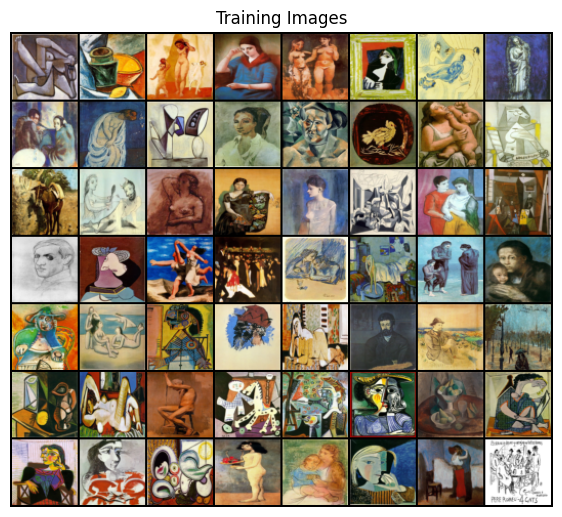

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:56], padding=2, normalize=True).cpu(),(1,2,0)))

### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),  # 4x4
            nn.Upsample(scale_factor=2),  # Replace ConvTranspose with Upsample
            nn.Conv2d(features_g * 16, features_g * 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(features_g * 8, features_g * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(features_g * 4, features_g * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(features_g * 2, channels_img, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


### Descriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout to prevent overfitting
            self._block(features_d, features_d * 2, 4, 2, 1),
            nn.Dropout(0.3),  # Dropout to prevent overfitting
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            nn.Dropout(0.3),  # Dropout to prevent overfitting
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)


## Setting the Model

In [8]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

In [9]:
def show_tensor_images(image_tensor, num_images=32, size=(1, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Start Training

Epoch [0/400] Batch 0/7                   Loss D: 0.6924, loss G: 1.7266 
 Disc Real Prob 0.6348494291305542 Disc Fake Prob 0.6301997900009155


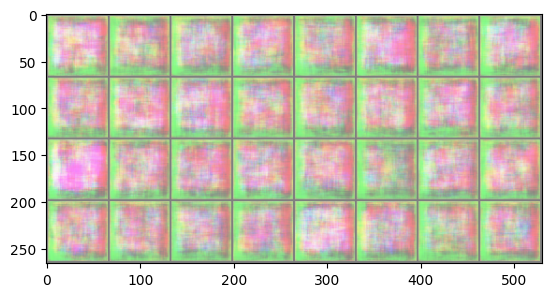

Epoch [1/400] Batch 0/7                   Loss D: 0.8835, loss G: 4.9706 
 Disc Real Prob 0.5972927808761597 Disc Fake Prob 0.6145457625389099
Epoch [2/400] Batch 0/7                   Loss D: 1.0720, loss G: 4.4951 
 Disc Real Prob 0.6257551908493042 Disc Fake Prob 0.639704704284668
Epoch [3/400] Batch 0/7                   Loss D: 1.4650, loss G: 3.0224 
 Disc Real Prob 0.6099256873130798 Disc Fake Prob 0.6830949187278748
Epoch [4/400] Batch 0/7                   Loss D: 0.5490, loss G: 3.2609 
 Disc Real Prob 0.6681615114212036 Disc Fake Prob 0.5985466837882996
Epoch [5/400] Batch 0/7                   Loss D: 0.9548, loss G: 1.8789 
 Disc Real Prob 0.6260960102081299 Disc Fake Prob 0.6415079832077026
Epoch [6/400] Batch 0/7                   Loss D: 0.5910, loss G: 2.0149 
 Disc Real Prob 0.6437022089958191 Disc Fake Prob 0.5970259308815002
Epoch [7/400] Batch 0/7                   Loss D: 0.4798, loss G: 1.4583 
 Disc Real Prob 0.6639962792396545 Disc Fake Prob 0.5975029468536377


In [10]:
# Initialize lists to store discriminator probabilities for real and fake images
disc_real_probs = []
disc_fake_probs = []

# Training loop
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _ ) in enumerate(dataloader):
        real = real.to(device)
        
        ### create noise tensor
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        disc_fake = disc(fake.detach()).reshape(-1)
        
        #converted prob
        real_prob = torch.sigmoid(disc_real).mean().item()
        fake_prob = torch.sigmoid(disc_fake).mean().item()

        # Store the discriminator probabilities for real and fake images
        disc_real_probs.append(real_prob)
        disc_fake_probs.append(fake_prob)
        
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        ### Print losses occasionally and fake images occasionally
        if batch_idx % 50 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f} \n Disc Real Prob {real_prob} Disc Fake Prob {fake_prob}"
            )
            if epoch % 10 == 0: 
                with torch.no_grad():
                    fake = gen(fixed_noise)
                    img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                    img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                    show_tensor_images(img_grid_fake)
            
        

# Plotting the probabilities
plt.figure(figsize=(10, 5))
plt.title("Discriminator Real vs Fake Probabilities")
plt.plot(disc_real_probs, label="Real Images")
plt.plot(disc_fake_probs, label="Fake Images")
plt.xlabel("Iterations")
plt.ylabel("Probability")
plt.legend()
plt.show()
